In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['font.family']= 'open sans'

from scipy import stats
from mpmath import hyp3f2, hyp2f1, beta
from statsmodels.stats.diagnostic import normal_ad


from rdn.defaults import pardict_from_result
from rdn.fitting import population_fits
from rdn.fitting.pipeline import *
from rdn.fitting.models import LocalGaussModelTilde, MultiInterface
from rdn.fitting.losses import *

from rdn.stochastic.experiments import linear_experiment


Import helm data

In [4]:
helm_df = pd.read_csv('data/validation_data/helm_data/lognom_proteins.csv')

# Figure S12

In [5]:
def lognorm_plot(ax, data, n_bins=9, **kwargs):
    
    _, p = normal_ad(data)
    print(len(data))
    
    _, bins, _ = ax.hist(data, bins=n_bins, density=True,
        color=kwargs.get('color'), alpha=kwargs.get('alpha'),
    )

    if p >= 0.05:

        res = stats.norm.fit(data)
        
        if kwargs.get('x_lim') is None: x_lim = (bins[[0,-1]]-bins.mean())*1.5 +bins.mean()
        else: x_lim = kwargs.get('x_lim')

        X = np.linspace(x_lim[0], x_lim[1],100)
        fitline = ax.plot(X, stats.norm.pdf(X, *res), color=kwargs.get('linecolor'), linewidth=3)

    ax.set_xticks(bins[[0,-1]], (f'{bins[0]:.1f}',f'{bins[-1]:.1f}'))
    ax.set_yticks([])
    
    for k, v in ax.spines.items(): 
        if k != 'bottom': v.set_visible(False)

    # External formatting
    ax.set_xlim(x_lim)
    ax.set_xlabel(kwargs.get('xlabel'), labelpad=0, fontsize=12)
    ax.set_ylabel(kwargs.get('ylabel'), labelpad=0, fontsize=12)

    if p >= 0.05: return p, fitline
    else: return None, None
    

def correlation_plot(ax, X, Y, **kwargs):
    s,i,r,p,e = stats.linregress(X,Y)

    ax.scatter(X,Y, 
        color=kwargs.get('color'), 
        alpha=kwargs.get('alpha'),
        linewidths=0,
        s=22,
    )

    if p < 0.05:
        XX = np.linspace(X.min(), X.max(), 2)
        line = ax.plot(
            XX, i + s*XX, 
            color=kwargs.get('linecolor'),
            linestyle=(0,(5,3)),
            linewidth=2,
        )
        # print(p)

    for s in ax.spines.values():
        s.set_visible(True)

    ax.set_xlabel(kwargs.get('xlabel'), labelpad=0, fontsize=12)
    ax.set_ylabel(kwargs.get('ylabel'), labelpad=0, fontsize=12)

    if p < 0.05: return r, line
    else: return None, None


def custom_probplot(ax, data, **kwargs):
    (osm, osr), (s, i, r) = stats.probplot(data)

    ax.scatter(osm, osr, s=20, c=kwargs.get('color'))
    ax.plot(osm, i + s*osm, color='tab:orange' )

    for s in ax.spines.values(): s.set_visible(True)

    ax.set_xlabel('Theoretical Q', fontsize=12, labelpad=0)
    ax.set_ylabel('Observed Q', fontsize=12, labelpad=0)

135
62
110
86
53
139
97
37
34
91
133


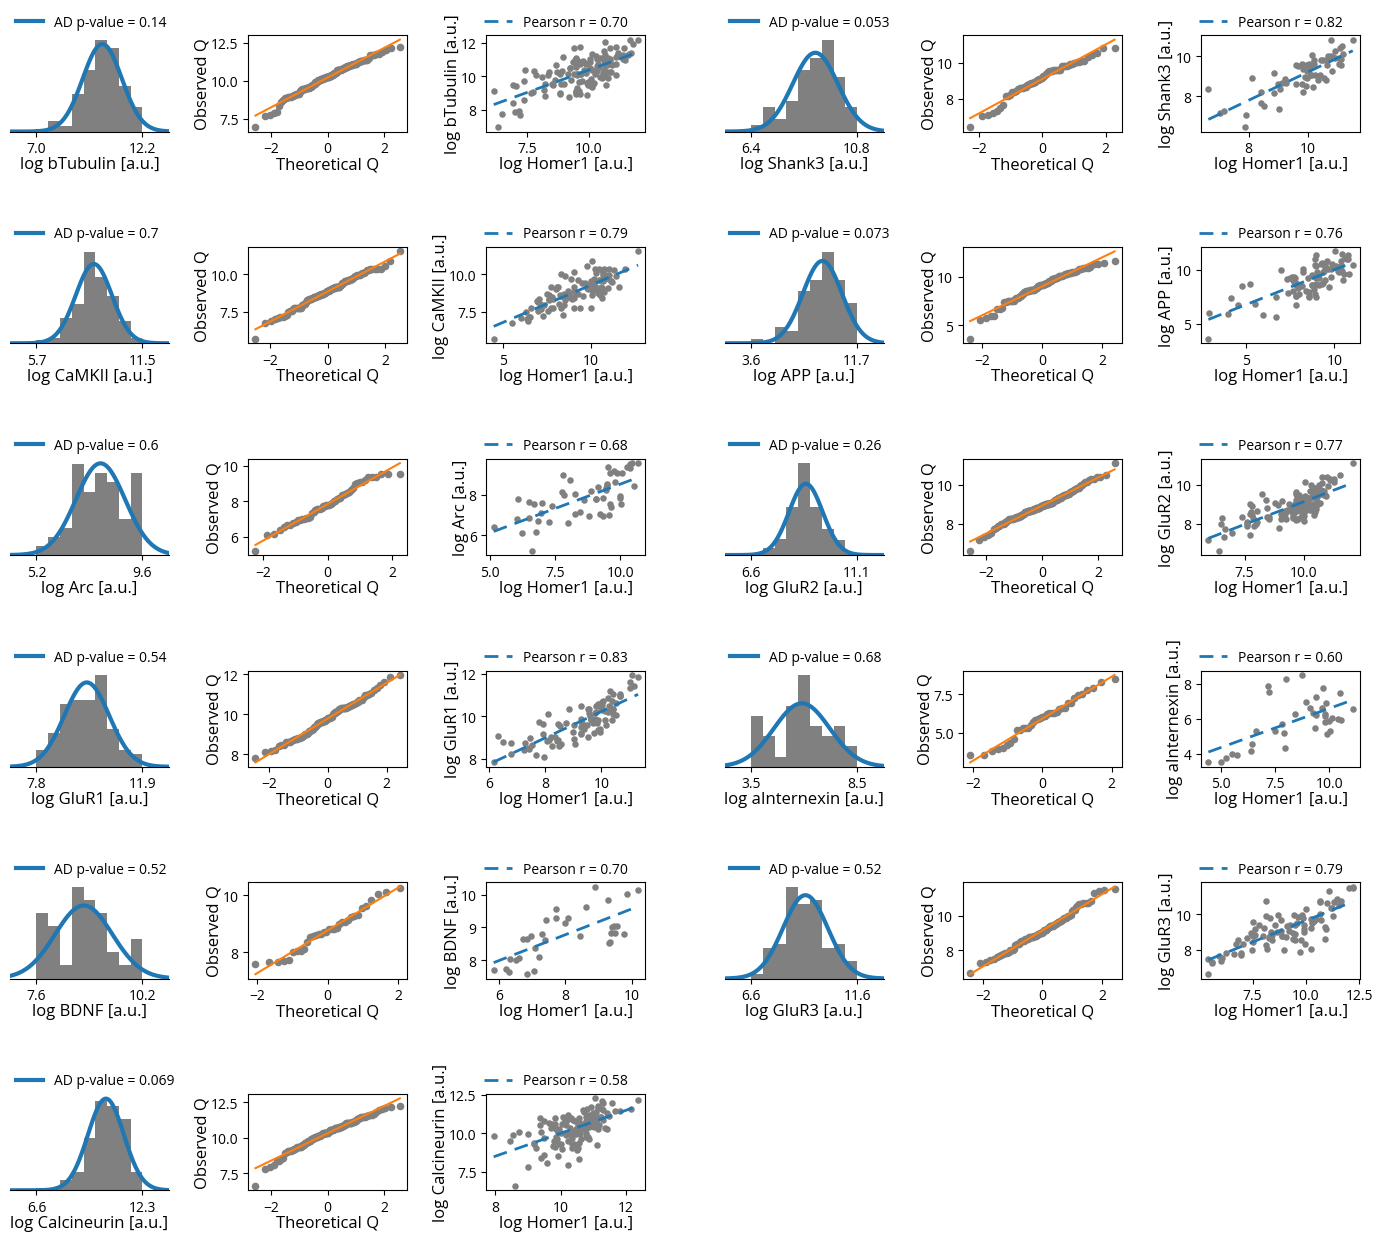

In [6]:
proteins = helm_df['protein'].unique().tolist()

fig, axs = plt.subplots(6, 6, figsize=(15,15))
fig.subplots_adjust(hspace=1.2, wspace=0.5, left=0.1, right=1)

axs_hist = axs[:,[0,3]].flatten()
axs_qq = axs[:,[1,4]].flatten()
axs_corr = axs[:,[2,5]].flatten()

for ah, aq, ac,  p in zip(axs_hist, axs_qq, axs_corr, proteins):
    poi = helm_df[helm_df['protein']==p]['poi']
    homer = helm_df[helm_df['protein']==p]['Homer']

    pval, log_line = lognorm_plot(ah, poi, color='gray')
    custom_probplot(aq, poi, color='gray')

    r, r_line = correlation_plot(ac, homer, poi, color='gray')
    
    ah.legend(
        log_line, 
        [f'AD p-value = {pval:.2}'], 
        loc=[0,1],
        frameon=False,
    )
    ac.legend(
        r_line,
        [f'Pearson r = {r:.2f}'],
        loc=[-0.05,1],
        frameon=False,
    )

    ah.set_xlabel(f'log {p} [a.u.]')


    ac.set_xlabel('log Homer1 [a.u.]')
    ac.set_ylabel(f'log {p} [a.u.]')
    
for ax in axs[-1,3:]: ax.remove()

# plt.savefig('docs/figures-paper/supplementary/lognorm-proteins.png', dpi=300)